# Assignment 1: Data Collection and Prompt Engineering (10%)

This assignment requires students to create a data set for training and evaluation of an SUTD chatbot for prospective students. The data set should contain documents about SUTD and question-answer pairs suitable for model training and evaluation.

In addition to the data set, students should build a first prototype using only prompt engineering and foundation models available via APIs.

Objectives:
- Collect and curate documents related to SUTD (programs, admissions, campus, scholarships, student life, FAQs, policies).
- Create a high-quality Q&A dataset suitable for training and evaluation.
- Build a prompt-engineered chatbot prototype using a foundation model API with [Amazon Bedrock — What is Bedrock?](https://docs.aws.amazon.com/bedrock/latest/userguide/what-is-bedrock.html).
- Evaluate prototype responses against the curated Q&A dataset.

Deliverables:
- Data artifact: documents (raw + cleaned), Q&A pairs (JSONL), metadata (sources, timestamps, licenses).
- Notebook: end-to-end workflow (collection → cleaning → Q&A generation → prototype → evaluation).
- Short report: methodology, data sources, prompt design, evaluation summary.

Grading (10%):
- Data quality and coverage (3%)
- Q&A diversity, clarity, and correctness (3%)
- Prototype design and prompt engineering (2%)
- Evaluation thoroughness and analysis (2%)


# Setup & Environment

This notebook uses Python. If you use external APIs (e.g., AWS Bedrock), store credentials in environment variables and load them securely (do not hardcode keys).

Recommended packages:
- requests, beautifulsoup4, pandas, numpy, tqdm
- scikit-learn (optional for baseline retrieval)
- openai OR anthropic OR boto3 (choose one API path)
- rouge-score OR evaluate (optional, for metrics)

Tip: Use a virtual environment and a `.env` file or system keychain.

Example environment variables:
- OPENAI_API_KEY
- ANTHROPIC_API_KEY
- AWS_REGION + AWS credentials for Bedrock


# Data Collection

Collect documents about SUTD from official, public sources (admissions pages, program descriptions, campus life, FAQ, scholarship info, policies). Respect robots.txt and terms of use; avoid overloading servers, and cache downloads locally.

Suggested steps:
1. Identify seed URLs and a scope definition (which pages to include).
2. Fetch pages politely (rate limiting), parse text, and store raw HTML + cleaned text.
3. Track metadata: URL, title, section, timestamp, retrieval status, license.
4. Normalize and deduplicate content; segment long pages into sections.

Artifacts:
- data/raw/*.html
- data/processed/*.md or *.txt
- data/metadata.csv


### **Fetching raw HTML from SUTD FAQ website**

To ground the chatbot in official university information, I collected content from the SUTD Undergraduate Admissions FAQ website.
The FAQ content spans 9 paginated pages, each containing multiple question-and-answer entries.
All source URLs were stored in ```data/seed_urls.txt```



The data ingestion pipeline is implemented as a Python script (`fetch_html.py`), and its structure is as follows:

`seed_urls.txt --> fetch_html.py --> raw HTML files + metadata.csv`

The script does the following:
1. Read seed URLS
2. Send HTTP requests (implementing a delay to avoid spam)
3. Save each page's HTML under `data/raw`
4. Record retrieval metadata in `data/metadata.csv`

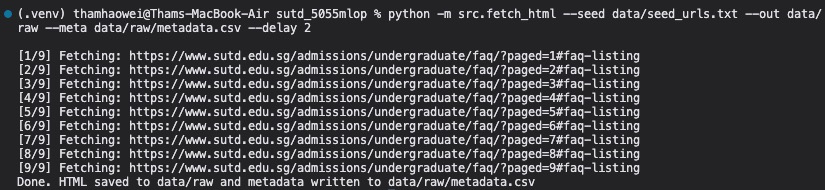

### ** Data Preparation — Extracting FAQ Q&A from Raw HTML**

After downloading the FAQ pages as raw HTML, I parse each page and extract only the FAQ entries, excluding other text on the page like the headers. This is done using `src/extract_faq.py`

Inputs: `data/raw/NAME.html`

Outputs: `data/processed/NAME_faq.txt` (one file per page)

The pipeline is as follows:
```
data/raw/*.html --> extract_faq.py --> data/processed/*_faq.txt
```

### **Data Preparation — Extracting FAQ Q&A and Constructing the Corpus**

After collecting the raw HTML pages, the next step is to parse each FAQ page and extract structured Question–Answer pairs.

The SUTD FAQ website is implemented as an **accordion webpage**.  
Each FAQ entry follows a consistent HTML structure:

- Question: `<h6>` element
- Answer: next `<div class="richText">` block

The extraction is performed using the standalone script:

`src/extract_faq.py`

This script:
1. Reads each HTML file from `data/raw/`
2. Locates the FAQ accordion container
3. Extracts all Question–Answer pairs
4. Saves one text file per page
5. Combines all pages into a single corpus `data/processed/sutd_undergrad_faq_all.txt`
6. Verifies the number of extracted questions
7. Archives the per-page files into `data/archive`

An example of what the output file would like is shown in the screenshot below:

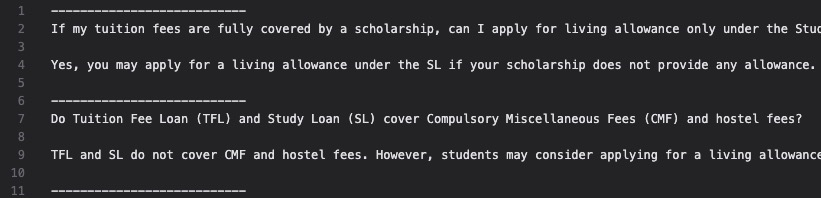

### **Grounding Preparation: Detecting External Information Dependencies**

During inspection of the FAQ pages, I observed that many answers do not contain complete information.  
Instead, they redirect users to another official SUTD webpage via hyperlinks.

These answers are not useful to us.

Therefore, I implemented a filtering step using `src/extract_links.py`.

This script:
1. Parses each FAQ answer from the raw HTML files
2. Detects embedded hyperlinks
3. Separates entries into:
   - usable Q&A (no external links)
   - incomplete Q&A (contains links)
4. Records all referenced SUTD pages for future scraping inside the file `data/archive/faq_links_to_visit.csv`


Here is a screenshot from that file

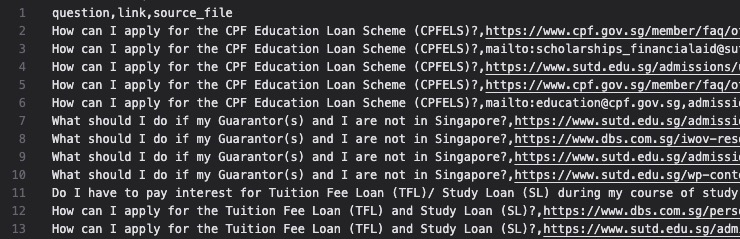

### **Additional Sources**

Beyond Admissions FAQ, using the links provided as well as sourcing on my own, I collected official SUTD webpages about:
- Undergraduate programme overview
- Freshmore subjects/curriculum
- Housing information (Freshmore)
- Rooms & amenities (Freshmore)

I saved these pages in `data/seed_urls_pages.txt`.

These pages are not in an accordion FAQ format, so I reuse `fetch_html.py` for downloading,
then use a new script, `extract_page_content.py`, to remove any irrelevant information such as headers and footers and keep only the main text content.

The raw extracted HTML files are saved to `data/raw`, and extracted content is in `data/processed/pages`, similar to what I did with the Admission FAQs.

# Q&A Generation

Create question-answer pairs suitable for model training and evaluation. Aim for coverage: admissions eligibility, deadlines, programs, curriculum, scholarships, housing, student life, application process, contact channels.

Options:
- Manual authoring from authoritative sources (preferred for correctness).
- LLM-assisted generation using your curated documents, followed by human validation.

Guidelines:
- Keep answers concise and factual; include references (URL, section) in metadata.
- Avoid speculative or outdated info; include retrieval timestamp.
- Provide diverse phrasings and difficulty levels.

# Dataset Assembly

Format the Q&A into a machine-learning friendly structure (JSONL recommended). Include:
- id, question, answer
- source (URL/file), retrieved_at timestamp
- split (train/test/dev), topic/category

Ensure a clear train/test split with no leakage.



### **Document Units**

Since each source document is short enough to fit into the model context window, I treat each cleaned file as one “document unit” for Q&A generation and evaluation.

I create a document registry that records:
- local file path
- source URL
- retrieval timestamp
- domain label (admissions / academics / housing)

This registry ensures reproducibility, in the sense that all generated Q&A pairs can be traced back to an official SUTD source and its retrieval time.

In [28]:
# Insert code here (if appropriate)

import pandas as pd
from pathlib import Path

ADM_PATH = Path("data/processed/faq_no_links.txt")
PAGES_DIR = Path("data/processed/pages")

ADM_META = Path("data/raw/metadata.csv")
PAGES_META = PAGES_DIR / "metadata.csv"

PAGE_FILES = [
    PAGES_DIR / "education_undergraduate_content.txt",
    PAGES_DIR / "education_undergraduate_freshmore-subjects_content.txt",
    PAGES_DIR / "campus-life_housing_freshmore_content.txt",
    PAGES_DIR / "campus-life_housing_freshmore_rooms-and-amenities_content.txt",
]

In [29]:
# for sanity check

adm_meta = pd.read_csv(ADM_META)
pages_meta = pd.read_csv(PAGES_META)

adm_meta.head(), pages_meta.head()

(                                                 url  \
 0  https://www.sutd.edu.sg/admissions/undergradua...   
 1  https://www.sutd.edu.sg/admissions/undergradua...   
 2  https://www.sutd.edu.sg/admissions/undergradua...   
 3  https://www.sutd.edu.sg/admissions/undergradua...   
 4  https://www.sutd.edu.sg/admissions/undergradua...   
 
                                             raw_path  status  \
 0  data/raw/admissions_undergraduate_faq_paged_1....     200   
 1  data/raw/admissions_undergraduate_faq_paged_2....     200   
 2  data/raw/admissions_undergraduate_faq_paged_3....     200   
 3  data/raw/admissions_undergraduate_faq_paged_4....     200   
 4  data/raw/admissions_undergraduate_faq_paged_5....     200   
 
                        retrieved_at   bytes  error  
 0  2026-02-24T09:40:13.151112+00:00  421438    NaN  
 1  2026-02-24T09:40:16.457132+00:00  420608    NaN  
 2  2026-02-24T09:40:18.804690+00:00  419313    NaN  
 3  2026-02-24T09:40:20.882304+00:00  421334    

In [30]:
# for retrieval timestamps

out_to_url = dict(zip(pages_meta["out_file"], pages_meta["source_url"]))

out_to_time = {}
if "retrieved_at" in pages_meta.columns:
    out_to_time = dict(zip(pages_meta["out_file"], pages_meta["retrieved_at"]))
else:
    raw_pages_meta_path = Path("data/raw/pages/metadata.csv")
    if raw_pages_meta_path.exists():
        raw_pages_meta = pd.read_csv(raw_pages_meta_path)
        rawfile_to_time = {Path(p).name: t for p, t in zip(raw_pages_meta["raw_path"], raw_pages_meta["retrieved_at"])}
        
        if "raw_file" in pages_meta.columns:
            out_to_time = {}
            for _, row in pages_meta.iterrows():
                out_file = row["out_file"]
                raw_file = row.get("raw_file", "")
                out_to_time[out_file] = rawfile_to_time.get(raw_file, "")
    # If nothing then leave blank

print("URL mapping:", out_to_url)
print("Timestamp mapping:", out_to_time)

URL mapping: {'campus-life_housing_freshmore_content.txt': 'https://www.sutd.edu.sg/campus-life/housing/freshmore/#tabs', 'campus-life_housing_freshmore_rooms-and-amenities_content.txt': 'https://www.sutd.edu.sg/campus-life/housing/freshmore/rooms-and-amenities/#tabs', 'education_undergraduate_content.txt': 'https://www.sutd.edu.sg/education/undergraduate', 'education_undergraduate_freshmore-subjects_content.txt': 'https://www.sutd.edu.sg/education/undergraduate/freshmore-subjects/'}
Timestamp mapping: {'campus-life_housing_freshmore_content.txt': '2026-02-24T16:53:13.989076+00:00', 'campus-life_housing_freshmore_rooms-and-amenities_content.txt': '2026-02-24T16:53:16.089208+00:00', 'education_undergraduate_content.txt': '2026-02-24T16:53:09.057783+00:00', 'education_undergraduate_freshmore-subjects_content.txt': '2026-02-24T16:53:11.186665+00:00'}


In [31]:
# for the retrieval faq

adm_retrieved_at = ""
if "retrieved_at" in adm_meta.columns:
    adm_retrieved_at = str(pd.to_datetime(adm_meta["retrieved_at"]).max())
else:
    adm_retrieved_at = ""

adm_source_url = "https://www.sutd.edu.sg/admissions/undergraduate/faq/ (multiple pages)"

adm_source_url, adm_retrieved_at

('https://www.sutd.edu.sg/admissions/undergraduate/faq/ (multiple pages)',
 '2026-02-24 09:40:31.697174+00:00')

### **Categorisation of documents**

I then categorised the 5 documents into 3 categories: admissions, academics and housing.

Documents were categorized into admissions, academics, and housing to improve dataset coverage and enable structured evaluation. This allows performance of the chatbot to be analyzed per domain (category) rather than relying on a single overall metric. 

Domain labels also help diagnose failures: if a housing question retrieves an academics document, then the issue is likely retrieval mismatch rather than model reasoning. 



In [32]:
docs = []

# Admissions doc
docs.append({
    "doc_id": "adm_faq_no_links",
    "domain": "admissions",
    "path": str(ADM_PATH),
    "source_url": adm_source_url,
    "retrieved_at": adm_retrieved_at
})

# Academics + Housing docs
for p in PAGE_FILES:
    out_file = p.name
    domain = "academics" if out_file.startswith("education_") else "housing"

    docs.append({
        "doc_id": out_file.replace("_content.txt", ""),  # simple stable id
        "domain": domain,
        "path": str(p),
        "source_url": out_to_url.get(out_file, ""),
        "retrieved_at": out_to_time.get(out_file, "")
    })

doc_registry = pd.DataFrame(docs)
#doc_registry

In [33]:
# sanity

def file_stats(path_str: str, preview_lines: int = 20):
    p = Path(path_str)
    text = p.read_text(encoding="utf-8", errors="ignore")
    lines = text.splitlines()
    return {
        "chars": len(text),
        "lines": len(lines),
        "preview": "\n".join(lines[:preview_lines])
    }

stats = []
for _, row in doc_registry.iterrows():
    s = file_stats(row["path"])
    stats.append({
        "doc_id": row["doc_id"],
        "domain": row["domain"],
        "chars": s["chars"],
        "lines": s["lines"]
    })

stats_df = pd.DataFrame(stats).sort_values(["domain", "doc_id"])
stats_df

,doc_id,domain,chars,lines
1,education_undergraduate,academics,7518,165
2,education_undergraduate_freshmore-subjects,academics,7292,99
0,adm_faq_no_links,admissions,22031,250
3,campus-life_housing_freshmore,housing,1330,9
4,campus-life_housing_freshmore_rooms-and-amenities,housing,1883,18


In [34]:
i = 0
row = doc_registry.iloc[i]
print("DOC:", row["doc_id"])
print("DOMAIN:", row["domain"])
print("SOURCE:", row["source_url"])
print("RETRIEVED_AT:", row["retrieved_at"])
print("\n--- PREVIEW ---\n")
print(file_stats(row["path"])["preview"])

DOC: adm_faq_no_links
DOMAIN: admissions
SOURCE: https://www.sutd.edu.sg/admissions/undergraduate/faq/ (multiple pages)
RETRIEVED_AT: 2026-02-24 09:40:31.697174+00:00

--- PREVIEW ---

--------------
If my tuition fees are fully covered by a scholarship, can I apply for living allowance only under the Study Loan (SL)?

Yes, you may apply for a living allowance under the SL if your scholarship does not provide any allowance.
--------------
Do Tuition Fee Loan (TFL) and Study Loan (SL) cover Compulsory Miscellaneous Fees (CMF) and hostel fees?

TFL and SL do not cover CMF and hostel fees. However, students may consider applying for a living allowance under the SL which can provide up to S$3,600 per year.
--------------
Do Tuition Fee Loan (TFL) and Study Loan (SL) cover full tuition fees for Singapore Permanent Residents (SPR) and International Students (IS)?

No. TFL and SL will not cover the tuition fees of SPR and IS in full as the loan amount is capped at the subsidised tuition fees 

In [35]:
out_path = Path("data/processed/doc_registry.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)

doc_registry.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data/processed/doc_registry.csv


### **Q-A Pair Generation**

I initially wanted to use Bedrock but there was an issue with my account which I escalated to their customer service agent, apparently as my account is new it takes a while for them to enable it. They say it should be resolved within 48h so I moved ahead with OpenAI LLM instead as I had leftover credits. Regardless, I left the code for Claude here below.

Question–answer pairs were generated using the OpenAI API. For each cleaned SUTD document, the full text was provided to the model together with a structured prompt instructing it to create concise, factual questions and answers intended for prospective students.

The prompt explicitly required the model to rely only on the provided document context, avoid external knowledge, and return results in strict JSON format. Outputs marked “UNANSWERABLE” were filtered out, and duplicate questions were removed. Generation was performed in small batches to reduce formatting errors and truncation, as I had faced issues such as hitting the max_token limit.

The resulting Q&A entries were saved in JSONL format together with metadata (source file, original URL, and retrieval timestamp) to maintain traceability.

In [36]:
# My AWS account did not have Bedrock enabled so I could not use it
# I contacted support who said they will get back to me in 48h
# I decided to move ahead w OpenAI as I had leftover credits, but left the Claude code here 

# %pip install -q boto3 

# import boto3
# import os

# REGION = os.getenv("AWS_DEFAULT_REGION", "us-east-1")

# bedrock = boto3.client(
#     service_name="bedrock-runtime",
#     region_name=REGION
# )

# print("Bedrock client ready")

# import json

# MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0"

# def claude(messages, max_tokens=800, temperature=0.2):
#     body = {
#         "anthropic_version": "bedrock-2023-05-31",
#         "max_tokens": max_tokens,
#         "temperature": temperature,
#         "messages": messages,
#     }

#     resp = bedrock.invoke_model(
#         modelId=MODEL_ID,
#         body=json.dumps(body).encode("utf-8"),
#         accept="application/json",
#         contentType="application/json",
#     )

#     payload = json.loads(resp["body"].read())
#     text = "".join(
#         block.get("text", "")
#         for block in payload.get("content", [])
#         if block.get("type") == "text"
#     )
#     return text

# response = claude([
#     {"role": "user", "content": "Reply with only the word: success"}
# ], max_tokens=20, temperature=0)

# print(response)

### Pilot Q-A generation

I first tested the model out on 1 subject (academics), to verify whether it works.

In [37]:
%pip install -q openai python-dotenv

import os
from dotenv import load_dotenv
from pathlib import Path

load_dotenv(Path(".env"))

assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY not found in .env"
print("OPENAI_API_KEY loaded ✅")

from openai import OpenAI

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def openai_text(prompt: str, model: str = "gpt-4o-mini", max_output_tokens: int = 300, temperature: float = 0.2) -> str:
    resp = client.responses.create(
        model=model,
        input=prompt,
        max_output_tokens=max_output_tokens,
        temperature=temperature,
    )
    return resp.output_text



Note: you may need to restart the kernel to use updated packages.
OPENAI_API_KEY loaded ✅


In [38]:
def llm(prompt: str) -> str:
    # later swap this to Bedrock Claude with the same signature
    return openai_text(prompt, model="gpt-4o-mini", max_output_tokens=2000, temperature=0.2)

In [39]:
from pathlib import Path

doc_path = Path("data/processed/pages/education_undergraduate_content.txt")
doc_text = doc_path.read_text(encoding="utf-8", errors="ignore")

len(doc_text), doc_text[:400]

(7518,
 'Design·AI Education\nUndergraduate studies at SUTD\nDesign·AI Education\nUndergraduate studies at SUTD\nEmbark on your academic journey at SUTD with a curriculum steeped in Design·AI and technology. Connect with like-minded peers in a collaborative, hands-on environment and develop innovative solutions that shape the future.\nDesign and Artificial Intelligence (Supercharged)\nThe future of design—where ')

In [40]:
import json

def qa_generation_prompt(doc_text: str, domain: str, n: int = 20) -> str:
    return f"""
You are generating a Q&A dataset for a grounded chatbot for prospective SUTD students.

STRICT RULES:
- Use ONLY the provided document text. Do NOT use outside knowledge.
- If not answerable from the text, set "answer" to "UNANSWERABLE".
- Answers must be concise (1–3 sentences).
- Output MUST be valid JSON only (no markdown, no commentary).
- Return exactly {n} items.

Return a JSON array of objects with keys:
question, answer, topic, difficulty

Allowed difficulty: easy, medium, hard
Allowed topic examples: admissions, deadlines, programs, curriculum, scholarships, housing, student_life, application_process, contact_channels

DOMAIN: {domain}

DOCUMENT TEXT:
\"\"\"{doc_text}\"\"\"
""".strip()

In [41]:
prompt = qa_generation_prompt(doc_text, domain="academics", n=20)
raw = llm(prompt)

# parse JSON
qas = json.loads(raw)

# drop unanswerable
qas = [x for x in qas if x.get("answer") != "UNANSWERABLE"]
len(qas), qas[0]

(19,
 {'question': 'What is the focus of the undergraduate curriculum at SUTD?',
  'answer': 'The undergraduate curriculum at SUTD focuses on Design·AI and technology, emphasizing a collaborative, hands-on environment.',
  'topic': 'curriculum',
  'difficulty': 'easy'})

In [42]:
import json
from pathlib import Path

out = Path("data/qa_academics.jsonl")

with out.open("w", encoding="utf-8") as f:
    for i, qa in enumerate(qas):
        qa["id"] = f"acad_{i:03d}"
        qa["source"] = "education_undergraduate_content.txt"
        qa["domain"] = "academics"
        f.write(json.dumps(qa, ensure_ascii=False) + "\n")

print("Saved to:", out)

Saved to: data/qa_academics.jsonl


### Automated Q-A Generation

Once I verified my OpenAI gpt 4o mini model was working, I then generated the Q-A pairs for all the topics together.

I included topic hints to guide the LLM to generate the right kinds of questions. This is done to avoid the LLM generating random questions like "What is SUTD?".

In [43]:
from pathlib import Path
import pandas as pd

DOCS = [
    {
        "path": "data/processed/faq_no_links.txt",
        "domain": "admissions",
        "topic_hint": "admissions, application_process, deadlines, scholarships"
    },
    {
        "path": "data/processed/pages/education_undergraduate_content.txt",
        "domain": "academics",
        "topic_hint": "programs, curriculum, learning, freshmore"
    },
    {
        "path": "data/processed/pages/education_undergraduate_freshmore-subjects_content.txt",
        "domain": "academics",
        "topic_hint": "freshmore subjects, curriculum structure"
    },
    {
        "path": "data/processed/pages/campus-life_housing_freshmore_content.txt",
        "domain": "housing",
        "topic_hint": "housing, hostel life, residential living"
    },
    {
        "path": "data/processed/pages/campus-life_housing_freshmore_rooms-and-amenities_content.txt",
        "domain": "housing",
        "topic_hint": "room types, facilities, amenities"
    },
]

doc_registry = pd.DataFrame(DOCS)
doc_registry

,path,domain,topic_hint
0,data/processed/faq_no_links.txt,admissions,"admissions, application_process, deadlines, sc..."
1,data/processed/pages/education_undergraduate_c...,academics,"programs, curriculum, learning, freshmore"
2,data/processed/pages/education_undergraduate_f...,academics,"freshmore subjects, curriculum structure"
3,data/processed/pages/campus-life_housing_fresh...,housing,"housing, hostel life, residential living"
4,data/processed/pages/campus-life_housing_fresh...,housing,"room types, facilities, amenities"


As earlier mentioned, I generated the Q-A pairs in batches as when I requested them all at once, it led to me exceeding the token limit and getting truncated outputs.

The prompt enforces grounded answers using only the document text, filters unanswerable questions, and removes duplicates to improve dataset quality.


In [44]:
import json
import re
from pathlib import Path


# cleans the raw LLM response and extracts only the JSON
def _extract_json_array(text: str) -> str:
    if not text:
        return ""
    text = re.sub(r"```(?:json)?\s*", "", text.strip(), flags=re.IGNORECASE)
    text = re.sub(r"\s*```", "", text.strip())
    start = text.find("[")
    end = text.rfind("]")
    if start == -1 or end == -1 or end < start:
        return ""
    return text[start:end+1]


def generate_qas_from_document_batched(
    doc_path: str,
    domain: str,
    topic_hint: str,
    n_total: int = 20,
    batch_size: int = 8,
    max_retries: int = 2
):
    """
    Generate QAs in multiple smaller batches to avoid output truncation.
    Deduplicates by question text.
    """
    text = Path(doc_path).read_text(encoding="utf-8", errors="ignore")

    all_qas = []
    seen_questions = set()

    # Number of batches (ceil)
    num_batches = (n_total + batch_size - 1) // batch_size

    for b in range(num_batches):
        remaining = n_total - len(all_qas)
        n = min(batch_size, remaining)
        existing_qs = "\n".join(f"- {q}" for q in list(seen_questions)[:30])  # cap to keep prompt short

        prompt = f"""
You are generating a Q&A dataset for a grounded chatbot for prospective SUTD students.

STRICT RULES:
- Use ONLY the provided document text. Do NOT use outside knowledge.
- If not answerable from the text, set "answer" to "UNANSWERABLE".
- Answers must be concise (1–3 sentences, <= 40 words).
- Output MUST be valid JSON only. No markdown, no backticks, no explanation.
- The first character of your output must be '[' and the last character must be ']'.
- Return exactly {n} items.

Avoid repeating any of these existing questions (if relevant):
{existing_qs if existing_qs else "(none yet)"}

Schema:
[
  {{
    "question": "...",
    "answer": "...",
    "topic": "...",
    "difficulty": "easy|medium|hard"
  }}
]

Topic hint: {topic_hint}
Domain: {domain}

DOCUMENT:
\"\"\"{text}\"\"\"
""".strip()

        last_raw = ""
        batch_qas = None

        for attempt in range(1, max_retries + 1):
            raw = llm(prompt)
            last_raw = raw

            json_text = _extract_json_array(raw)
            if not json_text:
                prompt = "RETURN ONLY JSON. " + prompt
                continue

            try:
                parsed = json.loads(json_text)
                # basic schema check
                if not isinstance(parsed, list):
                    raise ValueError("Output JSON is not a list")

                batch_qas = parsed
                break
            except Exception:
                prompt = "RETURN ONLY JSON (no extra text). " + prompt
                continue

        if batch_qas is None:
            raise ValueError(
                f"Failed to parse JSON batch {b+1}/{num_batches} for {doc_path}.\n"
                f"Raw preview:\n{last_raw[:800]}"
            )

        for qa in batch_qas:
            if qa.get("answer") == "UNANSWERABLE":
                continue
            q = (qa.get("question") or "").strip()
            if not q or q in seen_questions:
                continue
            seen_questions.add(q)
            all_qas.append(qa)

            if len(all_qas) >= n_total:
                break

        print(f"  Batch {b+1}/{num_batches}: kept {len(all_qas)}/{n_total}")

        if len(all_qas) >= n_total:
            break

    return all_qas

In [45]:
all_qas = []

for i, row in doc_registry.iterrows():
    print("Processing:", row["path"])

    qas = generate_qas_from_document_batched(
        doc_path=row["path"],
        domain=row["domain"],
        topic_hint=row["topic_hint"],
        n_total=60,       # target per doc
        batch_size=8    
    )

    for j, qa in enumerate(qas):
        qa["id"] = f"{row['domain']}_{i}_{j}"
        qa["source_file"] = row["path"]
        qa["domain"] = row["domain"]
        all_qas.append(qa)

print("Total QAs:", len(all_qas))

Processing: data/processed/faq_no_links.txt
  Batch 1/8: kept 8/60
  Batch 2/8: kept 16/60
  Batch 3/8: kept 23/60
  Batch 4/8: kept 26/60
  Batch 5/8: kept 29/60
  Batch 6/8: kept 30/60
  Batch 7/8: kept 30/60
  Batch 8/8: kept 31/60
Processing: data/processed/pages/education_undergraduate_content.txt
  Batch 1/8: kept 8/60
  Batch 2/8: kept 11/60
  Batch 3/8: kept 16/60
  Batch 4/8: kept 22/60
  Batch 5/8: kept 25/60
  Batch 6/8: kept 25/60
  Batch 7/8: kept 26/60
  Batch 8/8: kept 26/60
Processing: data/processed/pages/education_undergraduate_freshmore-subjects_content.txt
  Batch 1/8: kept 8/60
  Batch 2/8: kept 15/60
  Batch 3/8: kept 16/60
  Batch 4/8: kept 16/60
  Batch 5/8: kept 20/60
  Batch 6/8: kept 20/60
  Batch 7/8: kept 24/60
  Batch 8/8: kept 25/60
Processing: data/processed/pages/campus-life_housing_freshmore_content.txt
  Batch 1/8: kept 8/60
  Batch 2/8: kept 8/60
  Batch 3/8: kept 8/60
  Batch 4/8: kept 8/60
  Batch 5/8: kept 8/60
  Batch 6/8: kept 8/60
  Batch 7/8: 

In [46]:
# sanity check

print("RAW TYPE:", type(raw))
print("RAW LEN:", len(raw))
print("RAW PREVIEW:\n", raw[:500])

RAW TYPE: <class 'str'>
RAW LEN: 5458
RAW PREVIEW:
 [
    {
        "question": "What is the focus of the undergraduate curriculum at SUTD?",
        "answer": "The undergraduate curriculum at SUTD focuses on Design·AI and technology, emphasizing a collaborative, hands-on environment.",
        "topic": "curriculum",
        "difficulty": "easy"
    },
    {
        "question": "What are the three main building blocks of education at SUTD?",
        "answer": "The three main building blocks are the mandatory core curriculum, variable curriculum, 


In [47]:
import pandas as pd
from pathlib import Path

adm_meta = pd.read_csv("data/raw/metadata.csv")
pages_meta = pd.read_csv("data/processed/pages/metadata.csv")

adm_retrieved_at = str(pd.to_datetime(adm_meta["retrieved_at"]).max())
adm_source_url = "https://www.sutd.edu.sg/admissions/undergraduate/faq/ (multiple pages)"


out_to_url = dict(zip(pages_meta["out_file"], pages_meta["source_url"]))

out_to_time = {}
if "retrieved_at" in pages_meta.columns:
    out_to_time = dict(zip(pages_meta["out_file"], pages_meta["retrieved_at"]))
else:
    out_to_time = {k: "" for k in out_to_url.keys()}

adm_source_url, adm_retrieved_at

('https://www.sutd.edu.sg/admissions/undergraduate/faq/ (multiple pages)',
 '2026-02-24 09:40:31.697174+00:00')

In [48]:
# attach metadate to each q-a pair

from pathlib import Path

def attach_metadata(qa):
    src = qa["source_file"]
    p = Path(src)

    if p.name == "faq_no_links.txt":
        qa["source_url"] = adm_source_url
        qa["retrieved_at"] = adm_retrieved_at
    else:
        # pages use filename key
        out_file = p.name
        qa["source_url"] = out_to_url.get(out_file, "")
        qa["retrieved_at"] = out_to_time.get(out_file, "")

    return qa

all_qas = [attach_metadata(q) for q in all_qas]

# quick check
all_qas[0]

{'question': 'Can I apply for living allowance only under the Study Loan if my tuition fees are covered by a scholarship?',
 'answer': 'Yes, you may apply for a living allowance under the SL if your scholarship does not provide any allowance.',
 'topic': 'scholarships',
 'difficulty': 'easy',
 'id': 'admissions_0_0',
 'source_file': 'data/processed/faq_no_links.txt',
 'domain': 'admissions',
 'source_url': 'https://www.sutd.edu.sg/admissions/undergraduate/faq/ (multiple pages)',
 'retrieved_at': '2026-02-24 09:40:31.697174+00:00'}

Here I saved it to a file so I could manually review the questions (human verification).

In [112]:
# saving dataset as jsonl

import json
from pathlib import Path

out = Path("data/processed/qa_all.jsonl")
out.parent.mkdir(parents=True, exist_ok=True)

with out.open("w", encoding="utf-8") as f:
    for qa in all_qas:
        f.write(json.dumps(qa, ensure_ascii=False) + "\n")

print("Saved:", out, "| rows:", len(all_qas))

Saved: data/processed/qa_all.jsonl | rows: 100


In [88]:
import pandas as pd
from pathlib import Path

rows = []

for qa in all_qas:
    rows.append({
        "id": qa.get("id",""),
        "domain": qa.get("domain",""),
        "question": qa.get("question",""),
        "answer": qa.get("answer",""),
        "topic": qa.get("topic",""),
        "difficulty": qa.get("difficulty",""),
    })

df = pd.DataFrame(rows)

csv_out = Path("data/processed/qa_all_readable.csv")
df.to_csv(csv_out, index=False, encoding="utf-8-sig")

print("Saved readable dataset to:", csv_out)

Saved readable dataset to: data/processed/qa_all_readable.csv


After manually reviewing all the Q-A pairs, I found 3 to be inaccurate/vague.

An example is shown here:

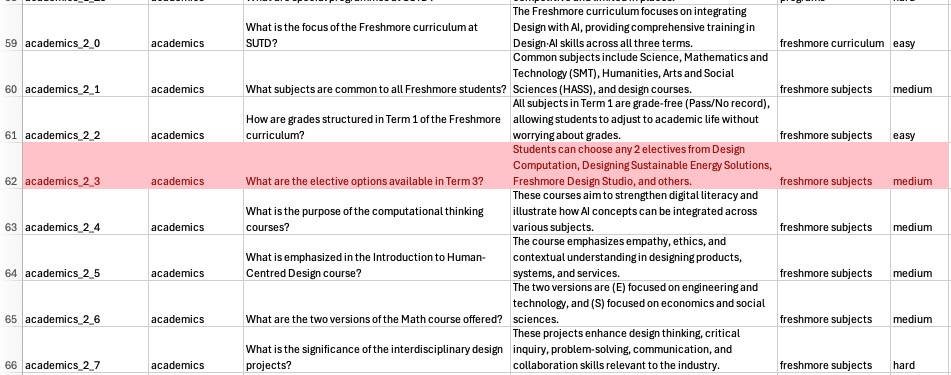

I remove them from the json file and update the new splits so they are excluded



In [121]:
import json
from pathlib import Path

BAD_IDS = {"admissions_0_2", "academics_1_0", "academics_2_3"}

path = Path("data/processed/qa_all.jsonl")

kept = []
removed = []

with path.open("r", encoding="utf-8") as f:
    for line in f:
        qa = json.loads(line)
        if qa.get("id") in BAD_IDS:
            removed.append(qa["id"])
        else:
            kept.append(qa)

# overwrite SAME file
with path.open("w", encoding="utf-8") as f:
    for qa in kept:
        f.write(json.dumps(qa, ensure_ascii=False) + "\n")

print("Removed IDs:", removed)
print("New dataset size:", len(kept))

Removed IDs: []
New dataset size: 98


In [122]:
import json
from pathlib import Path

# 1) Reload cleaned master dataset
all_qas = []
with open("data/processed/qa_all.jsonl", encoding="utf-8") as f:
    for line in f:
        all_qas.append(json.loads(line))

print("Reloaded qa_all.jsonl rows:", len(all_qas))

# 2) Rebuild splits
train, dev, test = [], [], []

for qa in all_qas:
    src = qa["source_file"]

    if src in train_files:
        qa["split"] = "train"
        train.append(qa)
    elif src in dev_files:
        qa["split"] = "dev"
        dev.append(qa)
    elif src in test_files:
        qa["split"] = "test"
        test.append(qa)
    else:
        qa["split"] = "train"
        train.append(qa)

print("New split sizes:", len(train), len(dev), len(test))

# 3) Save splits (overwrite)
def save_jsonl(path, rows):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")
    print("Saved:", path, "| rows:", len(rows))

save_jsonl("data/processed/qa_train.jsonl", train)
save_jsonl("data/processed/qa_dev.jsonl", dev)
save_jsonl("data/processed/qa_test.jsonl", test)

# 4) Reload test_data so evaluation uses the updated file
test_data = []
with open("data/processed/qa_test.jsonl", encoding="utf-8") as f:
    for line in f:
        test_data.append(json.loads(line))

print("Reloaded test_data rows:", len(test_data))

Reloaded qa_all.jsonl rows: 98
New split sizes: 63 0 35
Saved: data/processed/qa_train.jsonl | rows: 63
Saved: data/processed/qa_dev.jsonl | rows: 0
Saved: data/processed/qa_test.jsonl | rows: 35
Reloaded test_data rows: 35


### **Train/Test Split (Document-Level)**

This section assigns each QA to a dataset split based on its **source document** (not randomly).  
This is to avoid information leakage and give a more realistic evaluation of generalisation to unseen pages.

Initially, I planned a 3-way split (train/dev/test), but I later set `dev_files` to empty to allocate more data into the test set. (I hope) This is acceptable here because the dataset is small so evaluation can rely on train vs. test without a separate dev split. Regardless I left the initial code there commented out.

In [94]:
# train_files = {
#     "data/processed/faq_no_links.txt",
#     "data/processed/pages/education_undergraduate_content.txt",
#     "data/processed/pages/campus-life_housing_freshmore_content.txt",
# }

# dev_files = {
#     "data/processed/pages/education_undergraduate_freshmore-subjects_content.txt",
# }

# test_files = {
#     "data/processed/pages/campus-life_housing_freshmore_rooms-and-amenities_content.txt",
# }


train_files = {
    "data/processed/faq_no_links.txt",
    "data/processed/pages/education_undergraduate_content.txt",
    "data/processed/pages/campus-life_housing_freshmore_content.txt",
}

test_files = {
    "data/processed/pages/education_undergraduate_freshmore-subjects_content.txt",
    "data/processed/pages/campus-life_housing_freshmore_rooms-and-amenities_content.txt",
}

dev_files = set()  # leave empty


train, dev, test = [], [], []

for qa in all_qas:
    src = qa["source_file"]
    if src in train_files:
        qa["split"] = "train"
        train.append(qa)
    elif src in dev_files:
        qa["split"] = "dev"
        dev.append(qa)
    elif src in test_files:
        qa["split"] = "test"
        test.append(qa)
    else:
        # fallback: put unknowns into train
        qa["split"] = "train"
        train.append(qa)

len(train), len(dev), len(test)

(63, 0, 37)

In [95]:
def save_jsonl(path, rows):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")
    print("Saved:", path, "| rows:", len(rows))

save_jsonl("data/processed/qa_train.jsonl", train)
save_jsonl("data/processed/qa_dev.jsonl", dev)
save_jsonl("data/processed/qa_test.jsonl", test)

Saved: data/processed/qa_train.jsonl | rows: 63
Saved: data/processed/qa_dev.jsonl | rows: 0
Saved: data/processed/qa_test.jsonl | rows: 37


# Prompt-Engineered Prototype

Build a simple chatbot that answers prospective student questions using:
- A concise system prompt (tone: helpful, factual, official).
- Lightweight retrieval from your curated documents for grounding.
- A foundation model API (OpenAI, Anthropic, or AWS Bedrock).

Note: Do not include private keys in the notebook. Use environment variables.


In [52]:
# Insert code here (if appropriate)

%pip install -q scikit-learn

Note: you may need to restart the kernel to use updated packages.


This section reads the cleaned SUTD website text files and loads them into memory.  
Each document is stored together with its domain label so the retriever can later identify where an answer originated.

The texts are also collected into a list for vectorization in the retrieval stage.

In [96]:
from pathlib import Path
import pandas as pd

doc_registry = pd.DataFrame([
    {"path": "data/processed/faq_no_links.txt", "domain": "admissions"},
    {"path": "data/processed/pages/education_undergraduate_content.txt", "domain": "academics"},
    {"path": "data/processed/pages/education_undergraduate_freshmore-subjects_content.txt", "domain": "academics"},
    {"path": "data/processed/pages/campus-life_housing_freshmore_content.txt", "domain": "housing"},
    {"path": "data/processed/pages/campus-life_housing_freshmore_rooms-and-amenities_content.txt", "domain": "housing"},
])

documents = []
doc_texts = []

for _, row in doc_registry.iterrows():
    text = Path(row["path"]).read_text(encoding="utf-8", errors="ignore")
    documents.append({
        "path": row["path"],
        "domain": row["domain"],
        "text": text
    })
    doc_texts.append(text)

len(documents) # just to check

5

The documents are converted into TF-IDF vectors, which represent important words in each document numerically.  
This creates a searchable index so that user questions can be compared against documents using cosine similarity.

The resulting matrix is the retrieval index used to find relevant supporting documents.

In [97]:
# retriever 

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

doc_matrix = vectorizer.fit_transform(doc_texts)
doc_matrix.shape

(5, 1200)

This function retrieves the most relevant documents for a given question.  

The question is vectorized and compared against the document index using cosine similarity, and the top-k matching documents are returned.


In [98]:
# retrieval

def retrieve_docs(question, k=2):
    q_vec = vectorizer.transform([question])
    scores = cosine_similarity(q_vec, doc_matrix)[0]

    ranked_idx = scores.argsort()[::-1][:k]

    results = []
    for idx in ranked_idx:
        results.append({
            "path": documents[idx]["path"],
            "domain": documents[idx]["domain"],
            "text": documents[idx]["text"],
            "score": scores[idx]
        })

    return results

retrieve_docs("Do I need H2 Math to apply to SUTD?")

[{'path': 'data/processed/faq_no_links.txt',
  'domain': 'admissions',
  'text': '--------------\nIf my tuition fees are fully covered by a scholarship, can I apply for living allowance only under the Study Loan (SL)?\n\nYes, you may apply for a living allowance under the SL if your scholarship does not provide any allowance.\n--------------\nDo Tuition Fee Loan (TFL) and Study Loan (SL) cover Compulsory Miscellaneous Fees (CMF) and hostel fees?\n\nTFL and SL do not cover CMF and hostel fees. However, students may consider applying for a living allowance under the SL which can provide up to S$3,600 per year.\n--------------\nDo Tuition Fee Loan (TFL) and Study Loan (SL) cover full tuition fees for Singapore Permanent Residents (SPR) and International Students (IS)?\n\nNo. TFL and SL will not cover the tuition fees of SPR and IS in full as the loan amount is capped at the subsidised tuition fees for Singapore Citizens (SC).\n--------------\nCan I mail the Tuition Fee Loan (TFL)/ Study L

## "RAG" Pipeline

These sections implement the final grounded chatbot system.  

A user question is first used to retrieve the most relevant SUTD website documents, which are then inserted into a structured prompt and sent to the LLM together with strict behavior rules. This forces the model to answer only from retrieved context and return sources.

In [99]:
SYSTEM_PROMPT = """
You are the official SUTD undergraduate admissions assistant.

Rules:
- Answer ONLY using the provided context documents.
- If the information is not present, say:
  "I could not find this information in the official SUTD pages. Please check the SUTD website or contact admissions."

Tone:
- Helpful
- Professional
- Factual
- Concise (max 120 words)

Never:
- Invent deadlines, fees, GPA requirements, or policies
- Use outside knowledge
- Guess

Always prioritize correctness over completeness.
"""

In [100]:
def build_prompt(question):
    retrieved = retrieve_docs(question, k=2)

    context_blocks = []
    sources = []

    for r in retrieved:
        context_blocks.append(f"[SOURCE: {r['path']}]\n{r['text'][:3500]}")
        sources.append(r["path"])

    context_text = "\n\n".join(context_blocks)

    prompt = f"""
CONTEXT DOCUMENTS:
{context_text}

STUDENT QUESTION:
{question}

Answer the student using only the context above.
"""

    return prompt, sources

In [101]:
def chat(question):
    prompt, sources = build_prompt(question)

    response = llm(SYSTEM_PROMPT + "\n\n" + prompt)

    return {
        "question": question,
        "answer": response.strip(),
        "sources": sources
    }

Below are a few test questions I came up with myself to test it, the last one being a question which could not be answered from the info given, just to check that it does not make up random information or use external sources.

In [102]:
chat("Is Freshmore graded?")

{'question': 'Is Freshmore graded?',
 'answer': 'In Term 1, all subjects are grade-free (Pass/No record). Additionally, students can choose up to four more subjects from Terms 2 and 3 to be grade-free. This arrangement allows students to adjust to academic life at SUTD and explore new areas of interest without the pressure of grades.',
 'sources': ['data/processed/pages/campus-life_housing_freshmore_content.txt',
  'data/processed/pages/education_undergraduate_freshmore-subjects_content.txt']}

In [60]:
chat("I’m worried about living alone in my first year — will I have my own room, and if something goes wrong at night is there anyone around or is the hostel basically unsupervised?")

{'question': 'I’m worried about living alone in my first year — will I have my own room, and if something goes wrong at night is there anyone around or is the hostel basically unsupervised?',
 'answer': 'At SUTD, Freshmore students are paired in double rooms according to their class/cluster. While you will not have your own room, there are strong safety measures in place. The hostel has a 24/7 on-site security team, regular patrols, and monitored CCTVs. Additionally, live-in staff and student leaders are available to assist residents and foster a supportive community. If you have concerns or need help, you can easily reach out to them.',
 'sources': ['data/processed/pages/campus-life_housing_freshmore_rooms-and-amenities_content.txt',
  'data/processed/faq_no_links.txt']}

In [61]:
chat("how much does it cost to stay in freshmore hostel")

{'question': 'how much does it cost to stay in freshmore hostel',
 'answer': 'I could not find this information in the official SUTD pages. Please check the SUTD website or contact admissions.',
 'sources': ['data/processed/pages/campus-life_housing_freshmore_rooms-and-amenities_content.txt',
  'data/processed/pages/campus-life_housing_freshmore_content.txt']}

In summary, the chatbot uses lightweight document retrieval instead of full RAG chunking. Each user question is matched against the curated SUTD document set using TF-IDF similarity. The top-2 relevant documents are inserted into the model context.

A system prompt constrains the model to:
- answer only from the provided context
- maintain a factual and official tone
- refuse when information is unavailable

# Evaluation

Evaluate prototype answers against the Q&A dataset. Use a simple metric (e.g., token overlap or string similarity) and manual spot checks.

Suggested metrics:
- Exact match / normalized overlap
- ROUGE-L (optional)
- Human review with rubric (clarity, correctness, completeness, source alignment)


### **Evaluation Criteria**

I will evaluate 3 things:
1. Retrieval Quality: whether the correct document was retrieved to generate the answer (Top-k accuracy)
2. Answer Quality (F1 and Rouge-L)
3. Groundedness: Manually verifying all answers (including refusals, false positives and false negatives)

In [124]:
import json
from pathlib import Path

# Run chatbot on every test question and store outputs + sources
results = []

for i, item in enumerate(test_data):
    q = item["question"]
    gt = item["answer"]
    gt_src = item.get("source_file", "")

    chat_out = chat(q)  # uses retrieve_docs internally
    pred = chat_out["answer"]
    sources = chat_out.get("sources", [])

    results.append({
        "question": q,
        "ground_truth": gt,
        "prediction": pred,
        "ground_truth_source_file": gt_src,
        "retrieved_source_files": sources,
    })

# save to open n read ltr
out_path = Path("data/processed/test_results_full.jsonl")
out_path.parent.mkdir(parents=True, exist_ok=True)

with out_path.open("w", encoding="utf-8") as f:
    for r in results:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Saved:", out_path, "| rows:", len(results))

Saved: data/processed/test_results_full.jsonl | rows: 35


### Retrieval Quality: Top-k

In [125]:
def recall_at_k(results, k=1):
    hits = 0
    total = 0
    for r in results:
        gt_src = r.get("ground_truth_source_file", "")
        retrieved = r.get("retrieved_source_files", [])[:k]
        if gt_src:
            total += 1
            hits += int(gt_src in retrieved)
    return hits / total if total else 0.0

print("Recall@1:", recall_at_k(results, k=1))
print("Recall@2:", recall_at_k(results, k=2))

# print the fails
for r in results:
    if r.get("ground_truth_source_file") and (r["ground_truth_source_file"] not in r["retrieved_source_files"][:2]):
        print("\n--- RETRIEVAL FAIL ---")
        print("Q:", r["question"])
        print("GT source:", r["ground_truth_source_file"])
        print("Retrieved:", r["retrieved_source_files"][:2])

Recall@1: 0.9714285714285714
Recall@2: 1.0


### Answer Quality: F1 + ROUGE-L

In [134]:
import re
from collections import Counter

def normalize(text):
    text = (text or "").lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def f1_score(pred, truth):
    pred_tokens = normalize(pred).split()
    truth_tokens = normalize(truth).split()

    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return 0.0

    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

# F1
f1s = [f1_score(r["prediction"], r["ground_truth"]) for r in results]
print("Average F1:", sum(f1s)/len(f1s))

# ROUGE-L
%pip install -q rouge-score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rouges = [scorer.score(r["ground_truth"], r["prediction"])["rougeL"].fmeasure for r in results]
print("ROUGE-L:", sum(rouges)/len(rouges))

Average F1: 0.39586959600200117
Note: you may need to restart the kernel to use updated packages.
ROUGE-L: 0.3707597650832407


### Refusal-rate check

In [133]:
REFUSAL_PHRASE = "I could not find this information in the official SUTD pages."

refusals = [r for r in results if REFUSAL_PHRASE.lower() in r["prediction"].lower()]

print("Total refusals:", len(refusals), "/", len(results))

Total refusals: 8 / 35


In [129]:
import pandas as pd
import re
from pathlib import Path
from collections import Counter

REFUSAL_PHRASE = "I could not find this information in the official SUTD pages."

def normalize(text):
    text = (text or "").lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def f1_score(pred, truth):
    pred_tokens = normalize(pred).split()
    truth_tokens = normalize(truth).split()

    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return 0.0

    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())

    if num_same == 0:
        return 0.0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

rows = []

for r in results:

    pred = r["prediction"]
    gt = r["ground_truth"]

    if REFUSAL_PHRASE.lower() in pred.lower():
        auto_label = "refusal"

    else:
        f1 = f1_score(pred, gt)

        if f1 >= 0.50:
            auto_label = "correct"
        else:
            auto_label = "wrong"

    rows.append({
        "question": r["question"],
        "ground_truth": gt,
        "prediction": pred,
        "retrieved_source_1": r.get("retrieved_source_files", ["",""])[0],
        "retrieved_source_2": r.get("retrieved_source_files", ["",""])[1],
        "auto_assessment": auto_label,
        "label_correct": "",
    })

df = pd.DataFrame(rows)

out = Path("data/processed/manual_review.csv")
out.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out, index=False, encoding="utf-8-sig")

print("Saved CSV to:", out)

Saved CSV to: data/processed/manual_review.csv


I noticed alot of the answers marked as "wrong" were because the answers generated by the chatbot were too longwinded, when in reality, they were actually factually correct. An example is shown below:

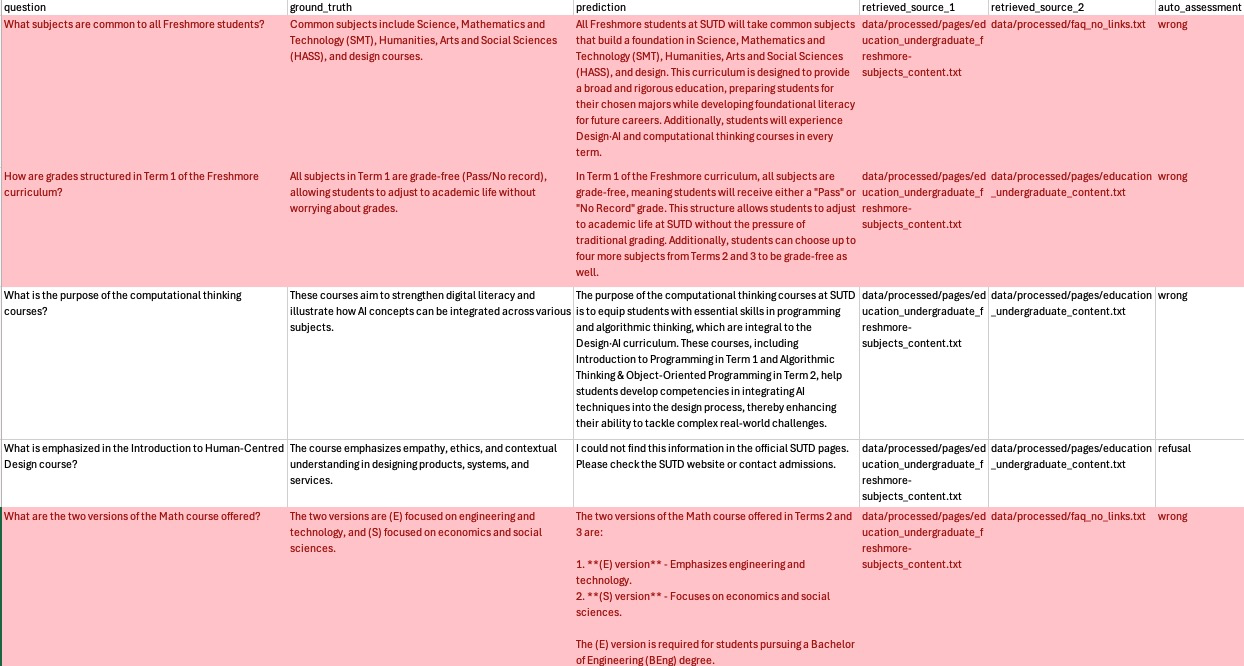

To fix this, I had 2 options:
1. Make the chatbot answer shorter
2. Make my evaluation less sensitive to verbosity (as F1 punishes extra words)

I chose to implement the second option. Instead of F1, I use recall to evaluate as it does not punish long answers. It is implemented below

In [130]:
import re
from collections import Counter

def normalize(text):
    text = (text or "").lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def token_recall(pred, truth):
    pred_tokens = normalize(pred).split()
    truth_tokens = normalize(truth).split()
    if not truth_tokens:
        return 0.0

    common = Counter(pred_tokens) & Counter(truth_tokens)
    num_same = sum(common.values())
    return num_same / len(truth_tokens)

In [131]:
REFUSAL_PHRASE = "I could not find this information in the official SUTD pages."

def auto_assess(pred, gt, recall_hi=0.70):
    pred_l = (pred or "").lower()

    if REFUSAL_PHRASE.lower() in pred_l:
        return "refusal"

    rec = token_recall(pred, gt)

    if rec >= recall_hi:
        return "correct"
    else:
        return "wrong"

In [132]:
import pandas as pd
from pathlib import Path

rows = []
for r in results:
    pred = r["prediction"]
    gt = r["ground_truth"]

    rec = token_recall(pred, gt)
    label = auto_assess(pred, gt)

    rows.append({
        "question": r["question"],
        "ground_truth": gt,
        "prediction": pred,
        "retrieved_source_1": r.get("retrieved_source_files", ["",""])[0],
        "retrieved_source_2": r.get("retrieved_source_files", ["",""])[1],
        "gt_token_recall": round(rec, 3),
        "auto_assessment": label,

        # you can still manually verify
        "label_correct": "",
        "notes": ""
    })

df = pd.DataFrame(rows)

out = Path("data/processed/manual_review.csv")
out.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out, index=False, encoding="utf-8-sig")

print("Saved CSV to:", out)
print(df["auto_assessment"].value_counts())

Saved CSV to: data/processed/manual_review.csv
auto_assessment
correct    25
refusal     8
wrong       2
Name: count, dtype: int64


This was a much better wat of evaluating the responses. After looking through every single test case, I identified which ones were 
- Wrongly identified as correct, meaning they are actually wrong(None)
- Wrongly identified as wrong, meaning they are actually correct (1/2)
- Wrongly identified as refusal, meaning it should have been able to get the answer from the document retrieved, but did not, instead saying no information could be found (8/8)

Surprisingly, all refusals were wrong, not in the sense that they used external sources, but that the information should have been found. Since the documents were short and the correct page was retrieved, the problem was not missing data or bad retrieval. The real issue was that the model could not identify the specific sentence in the text that answered the question. In other words, the chatbot had the information but failed to pick it out. Therefore, the main weakness of the system is not hallucination, but difficulty using the provided context, and the chatbot tends to refuse answering rather than risk giving an unsupported answer. However, this is still better than fabricating a fake answer for the sake of answering the question.

I saved the graded results in `data/processed/manual_review_excel.xltx`. Overall for the test results, after human verification, it had a success rate of 74% (26/35)

# End

This concludes Individual assignment 1.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** via github.


Every student should do the following submission steps:
1. Create a private github repository **sutd_5055mlops** under your github user.
2. Add your instructors as collaborator: ddahlmeier, bearwithchris and MarkHershey
3. Save your submission as `individual_assignment_01_StudentID`.ipynb (replace StudentID with your student ID)
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions 



**Assignment due 27 Feb (Fri) 23:59**